In [1]:
import numpy as np
import pyarrow.parquet as pq
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



# Examine one file only

In [2]:
# Read file
filename = "yellow_tripdata_2024-01.parquet"

# Just read the column that contains the date and time when meter was engaged (i.e. when trip started)
df = pq.read_table(filename, columns=["tpep_pickup_datetime"]).to_pandas()

# Cast the column straight away 
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 1 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
dtypes: datetime64[us](1)
memory usage: 22.6 MB


In [3]:
# Get the min and max of datetime
print(f"min_date_found: {df['tpep_pickup_datetime'].min()} ----- max_date_found: {df['tpep_pickup_datetime'].max()}")
print('------------')

# Lets find out the distribution of year-mm
df = df.sort_values(by='tpep_pickup_datetime')
df["year-month"] = df["tpep_pickup_datetime"].dt.strftime("%Y-%m")
print(df['year-month'].value_counts().sort_index())
print('------------')

min_date_found: 2002-12-31 22:59:39 ----- max_date_found: 2024-02-01 00:01:15
------------
year-month
2002-12          2
2009-01          3
2023-12         10
2024-01    2964606
2024-02          3
Name: count, dtype: int64
------------


In [4]:
# Filtering relevant month
datestring = filename.split("_")[-1].split(".")[0]
start_datetimestamp = pd.to_datetime(datestring, format='%Y-%m')

# Get the start of the next month
end_datetimestamp = start_datetimestamp + pd.DateOffset(months=1)

print(f"Filtering between these dates: {start_datetimestamp} and {end_datetimestamp}")
df = df[(df['tpep_pickup_datetime'] >= start_datetimestamp) & (df['tpep_pickup_datetime'] < end_datetimestamp)]
print(f"len_of_df_after_filtering: {len(df)}")

# Lets find out the distribution of year-mm again
print('------------')
df = df.sort_values(by='tpep_pickup_datetime')
print(df['year-month'].value_counts().sort_index())
print('------------')

Filtering between these dates: 2024-01-01 00:00:00 and 2024-02-01 00:00:00
len_of_df_after_filtering: 2964606
------------
year-month
2024-01    2964606
Name: count, dtype: int64
------------


In [5]:
# Drop the irrelevant column
df.drop("year-month", inplace=True, axis=1)

# Sort dataframe by datetime
df.sort_values(by="tpep_pickup_datetime", inplace=True)

# Now get the hourly counts of trip 
df = df.resample('h', on='tpep_pickup_datetime').size().reset_index(name="TotalTripsfrom_thishour_till_nexthour")

# Datasize after resampling
print(f"len_of_df_after_resampling: {len(df)}")

# Print min and max date
print(df["tpep_pickup_datetime"].min(), df["tpep_pickup_datetime"].max())

len_of_df_after_resampling: 744
2024-01-01 00:00:00 2024-01-31 23:00:00


In [6]:
# Make sure all hours are present (00:00:00 till 23:00:00)
print(f"Generating hourly timestamps from {start_datetimestamp} to {end_datetimestamp}")
complete_time_range = pd.date_range(start=start_datetimestamp, end=end_datetimestamp, inclusive='left', freq='h')
print( f"total_hourlytimestamps: {len(complete_time_range)}")

# Merge with the complete time range to find missing hours
df_full = pd.DataFrame({'tpep_pickup_datetime': complete_time_range})
df_full = df_full.merge(df, on='tpep_pickup_datetime', how='left')

# Total null values on hourly basis
missing_values = df_full["TotalTripsfrom_thishour_till_nexthour"].isna().sum()
print(f"Total number of hours missing from data: {missing_values}")

# Fill missing values with the average of the last two values
if missing_values > 0:
    print("filling NaNs with the rolling averages of last 2 entries")
    df_full['TotalTripsfrom_thishour_till_nexthour'] = df_full['TotalTripsfrom_thishour_till_nexthour'].fillna(
        df_full['TotalTripsfrom_thishour_till_nexthour'].rolling(2, min_periods=1).mean() 
        )


Generating hourly timestamps from 2024-01-01 00:00:00 to 2024-02-01 00:00:00
total_hourlytimestamps: 744
Total number of hours missing from data: 0


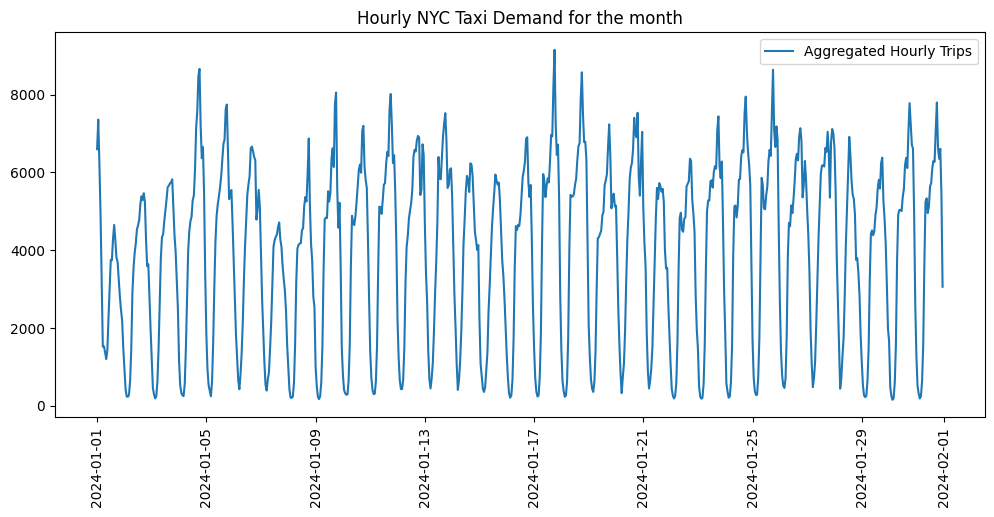

In [7]:
# Plot hourly demand
plt.figure(figsize=(12, 5))
plt.plot(df_full["tpep_pickup_datetime"], df_full["TotalTripsfrom_thishour_till_nexthour"], label="Aggregated Hourly Trips")
plt.title("Hourly NYC Taxi Demand for the month")
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Prepare Dataset

In [8]:
def prepare_datset(parquet_files):
    dataframes = []
    
    # Just read these columns
    column_headers = ["tpep_pickup_datetime"]
    
    for filename in parquet_files:
        # Just read the column that contains the date and time when meter was engaged (i.e. when trip started)
        print(f"-----> Reading {filename} ")
        df = pq.read_table(filename, columns=column_headers).to_pandas()

        # Cast the column straight away 
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
        print(df.info())
        print('-'*14)

        # Get the min and max of datetime
        print(f"min_date_found: {df['tpep_pickup_datetime'].min()} ----- max_date_found: {df['tpep_pickup_datetime'].max()}")
        print('------------')

        # Lets find out the distribution of year-mm
        df = df.sort_values(by='tpep_pickup_datetime')
        df["year-month"] = df["tpep_pickup_datetime"].dt.strftime("%Y-%m")
        print(df['year-month'].value_counts().sort_index())
        print('------------')

        # Filtering relevant month
        datestring = filename.split("_")[-1].split(".")[0]
        start_datetimestamp = pd.to_datetime(datestring, format='%Y-%m')

        # Get the start of the next month
        end_datetimestamp = start_datetimestamp + pd.DateOffset(months=1)
        print(f"Filtering between these dates: {start_datetimestamp} and {end_datetimestamp}")
        df = df[(df['tpep_pickup_datetime'] >= start_datetimestamp) & (df['tpep_pickup_datetime'] < end_datetimestamp)]
        print(f"len_of_df_after_filtering: {len(df)}")

        # Lets find out the distribution of year-mm again
        print('------------')
        df = df.sort_values(by='tpep_pickup_datetime')
        print(df['year-month'].value_counts().sort_index())
        print('------------')

        # Drop the irrelevant column
        df.drop("year-month", inplace=True, axis=1)

        # Sort dataframe by datetime
        df.sort_values(by="tpep_pickup_datetime", inplace=True)

        # Now get the hourly counts of trip 
        df = df.resample('h', on='tpep_pickup_datetime').size().reset_index(name="TotalTripsfrom_thishour_till_nexthour")

        # Datasize after resampling
        print(f"len_of_df_after_resampling: {len(df)}")

        # Print min and max date
        print(df["tpep_pickup_datetime"].min(), df["tpep_pickup_datetime"].max())


        # Make sure all hours are present (00:00:00 till 23:00:00)
        print(f"Generating hourly timestamps from {start_datetimestamp} to {end_datetimestamp}")
        complete_time_range = pd.date_range(start=start_datetimestamp, end=end_datetimestamp, inclusive='left', freq='h')
        print( f"total_hourlytimestamps: {len(complete_time_range)}")

        # Merge with the complete time range to find missing hours
        df_full = pd.DataFrame({'tpep_pickup_datetime': complete_time_range})
        df_full = df_full.merge(df, on='tpep_pickup_datetime', how='left')

        # Total null values on hourly basis
        missing_values = df_full["TotalTripsfrom_thishour_till_nexthour"].isna().sum()
        print(f"Total number of hours missing from data: {missing_values}")

        # Fill missing values with the average of the last two values
        if missing_values > 0:
            print("filling NaNs with the rolling averages of last 2 entries")
            df_full['TotalTripsfrom_thishour_till_nexthour'] = df_full['TotalTripsfrom_thishour_till_nexthour'].fillna(
                df_full['TotalTripsfrom_thishour_till_nexthour'].rolling(2, min_periods=1).mean() 
                )
          

        
        # Append dataframes
        dataframes.append(df_full)

        # delete
        del df
        del df_full
        print("\n\n")
    
    # Get the dataframe
    df = pd.concat(dataframes)
    del dataframes
    
    return df

In [9]:
# Read dataset
list_of_files = ['yellow_tripdata_2024-01.parquet', 'yellow_tripdata_2024-02.parquet', 'yellow_tripdata_2024-03.parquet']

# Read the dataset
dataset = prepare_datset(parquet_files=list_of_files)

# Reset index
dataset.reset_index(drop=True, inplace=True)


-----> Reading yellow_tripdata_2024-01.parquet 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 1 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
dtypes: datetime64[us](1)
memory usage: 22.6 MB
None
--------------
min_date_found: 2002-12-31 22:59:39 ----- max_date_found: 2024-02-01 00:01:15
------------
year-month
2002-12          2
2009-01          3
2023-12         10
2024-01    2964606
2024-02          3
Name: count, dtype: int64
------------
Filtering between these dates: 2024-01-01 00:00:00 and 2024-02-01 00:00:00
len_of_df_after_filtering: 2964606
------------
year-month
2024-01    2964606
Name: count, dtype: int64
------------
len_of_df_after_resampling: 744
2024-01-01 00:00:00 2024-01-31 23:00:00
Generating hourly timestamps from 2024-01-01 00:00:00 to 2024-02-01 00:00:00
total_hourlytimestamps: 744
Total number of hours missing from data: 

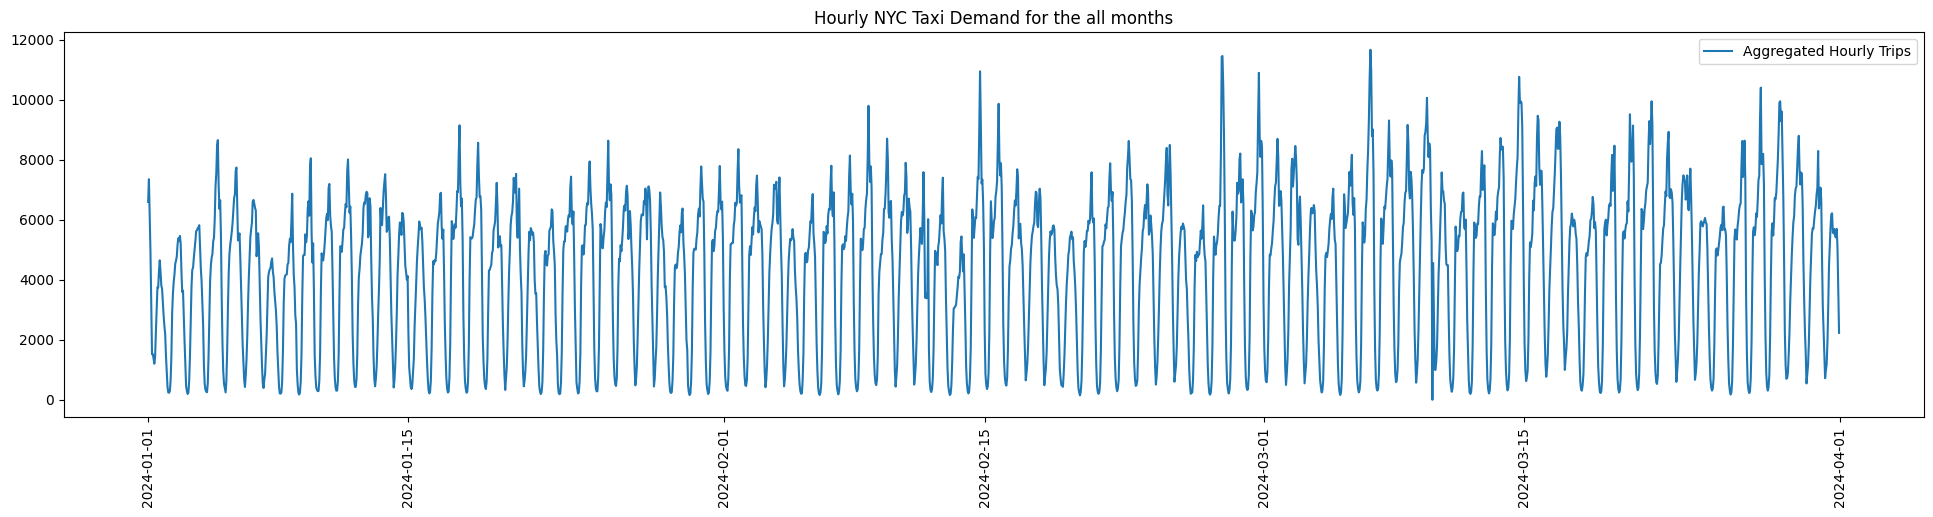

In [10]:
# Plot the timeseries
plt.figure(figsize=(24, 5))
plt.plot(dataset["tpep_pickup_datetime"], dataset["TotalTripsfrom_thishour_till_nexthour"], label="Aggregated Hourly Trips")
plt.title("Hourly NYC Taxi Demand for the all months")
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

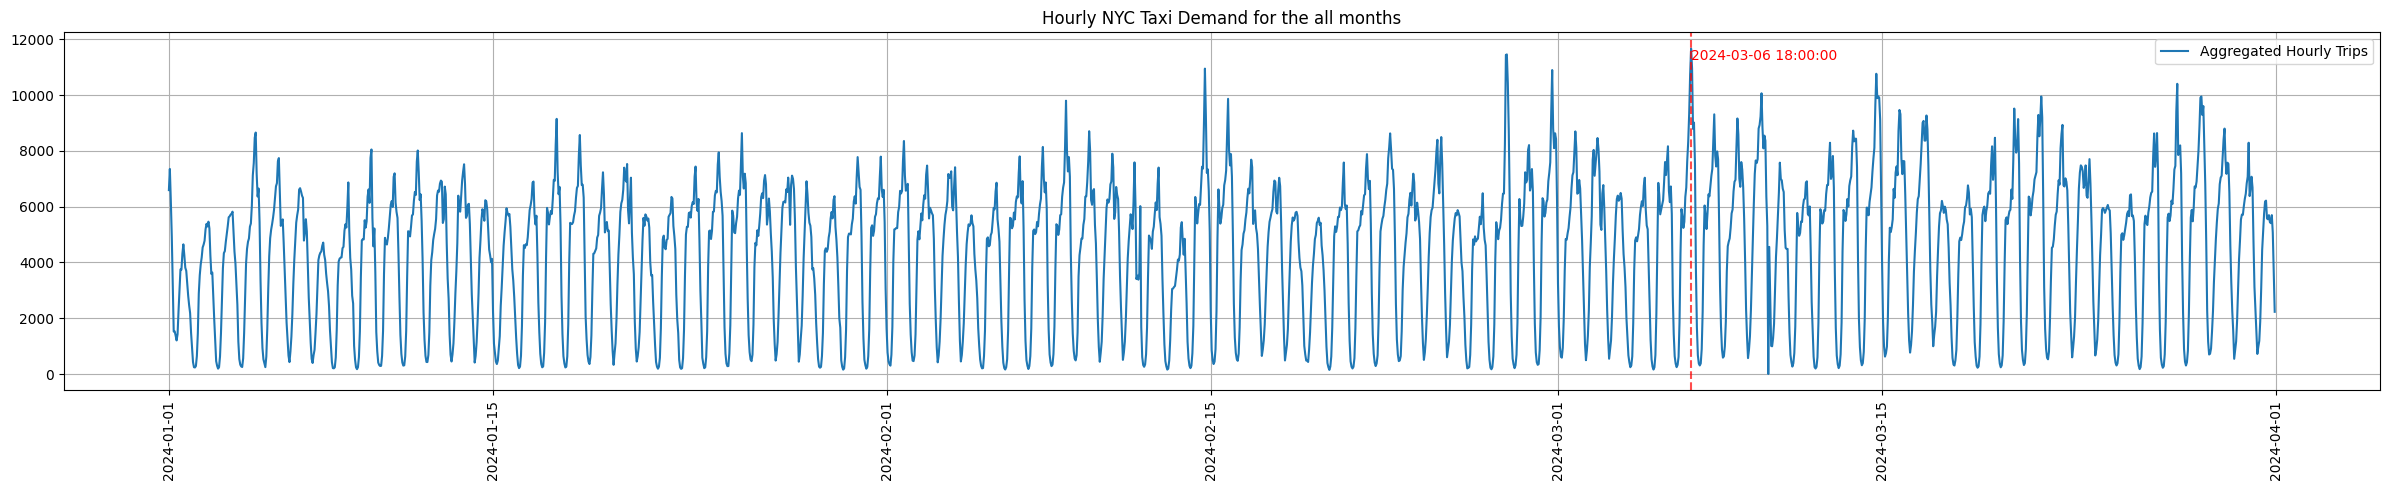

In [11]:
# Define major events and their times
events = {
    '2024-03-06 18:00:00': '2024-03-06 18:00:00',
}

# Convert event times to datetime
events = {event: pd.to_datetime(time) for event, time in events.items()}

# Plot time series
plt.figure(figsize=(24, 5))
plt.plot(dataset["tpep_pickup_datetime"], dataset["TotalTripsfrom_thishour_till_nexthour"], label="Aggregated Hourly Trips")
plt.title("Hourly NYC Taxi Demand for the all months")

# Mark events on the plot
for event, time in events.items():
    plt.axvline(x=time, color='red', linestyle='--', alpha=0.7)
    plt.text(time, plt.ylim()[1]*0.95, event, rotation=0, verticalalignment='top', color='red')

# Plot the timeseries
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
dataset.head(5)

,tpep_pickup_datetime,TotalTripsfrom_thishour_till_nexthour
0,2024-01-01 00:00:00,6596
1,2024-01-01 01:00:00,7355
2,2024-01-01 02:00:00,6220
3,2024-01-01 03:00:00,4936
4,2024-01-01 04:00:00,3188


# Visualize Patterns

In [13]:
del df
df = dataset.copy()

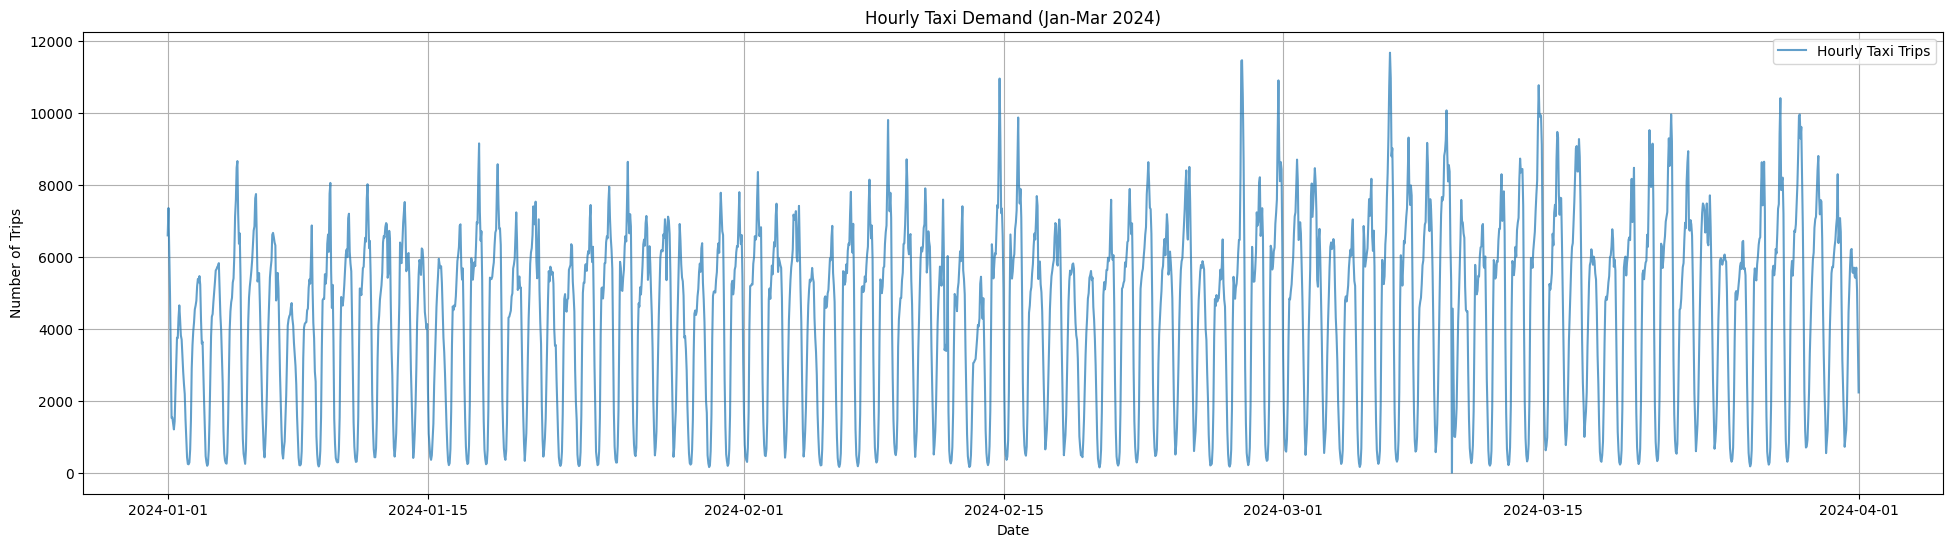

In [14]:
# Convert datetime column to pandas datetime format
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df.set_index("tpep_pickup_datetime", inplace=True)

# Plot the trip count over time
plt.figure(figsize=(24, 6))
plt.plot(df.index, df["TotalTripsfrom_thishour_till_nexthour"], label="Hourly Taxi Trips", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.title("Hourly Taxi Demand (Jan-Mar 2024)")
plt.legend()
plt.grid(True)
plt.show()


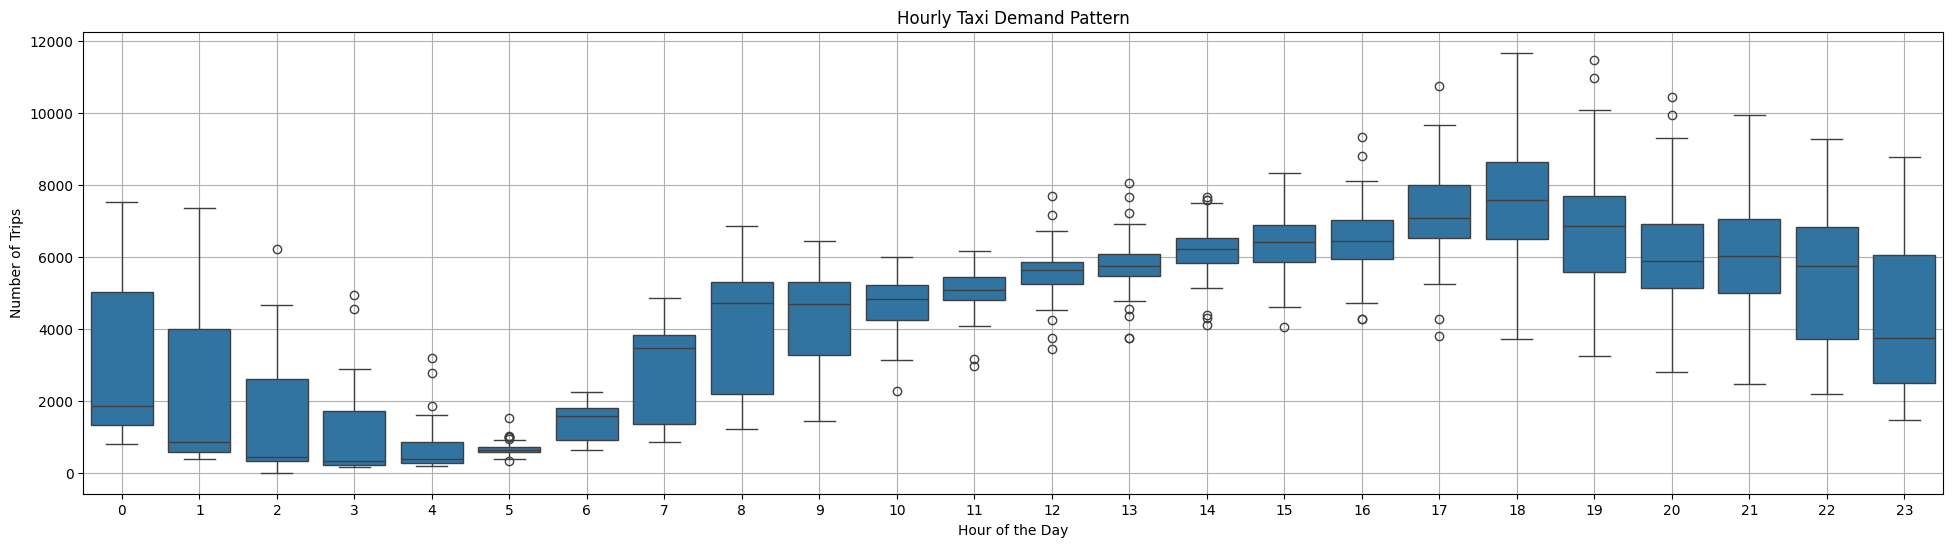

In [15]:
# Extract time-based features
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek

# Plot average trip demand by hour of the day
plt.figure(figsize=(24, 6))
sns.boxplot(x=df["hour"], y=df["TotalTripsfrom_thishour_till_nexthour"])
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Hourly Taxi Demand Pattern")
plt.grid(True)
plt.show()


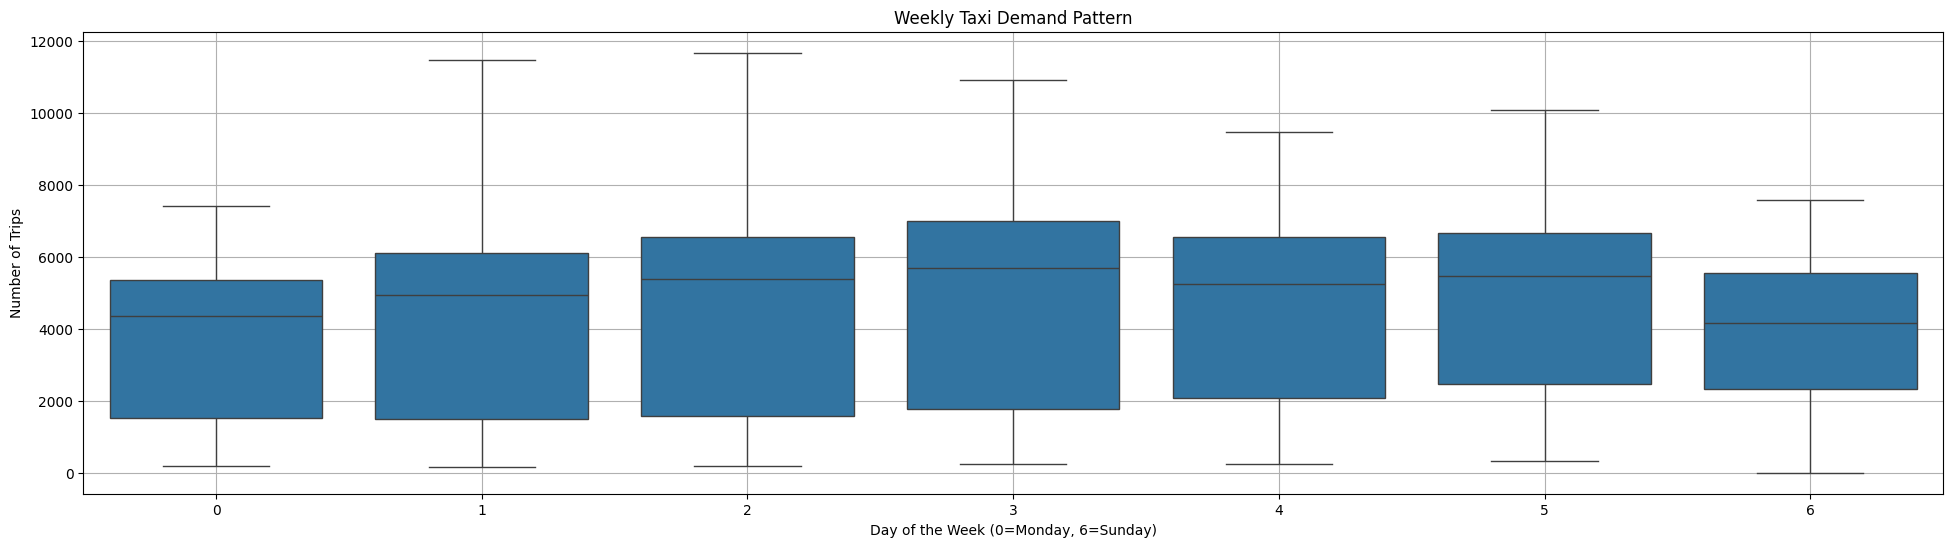

In [16]:
# Plot average trip demand by day of the week
plt.figure(figsize=(24, 6))
sns.boxplot(x=df["day_of_week"], y=df["TotalTripsfrom_thishour_till_nexthour"])
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Trips")
plt.title("Weekly Taxi Demand Pattern")
plt.grid(True)
plt.show()


# Model Training - SARIMAX


In [17]:
# Split into training and testing sets
train_size = int(len(dataset) * 0.8)  # 80% training, 20% testing
train, test = dataset.iloc[0:train_size, :].copy(), dataset.iloc[train_size:len(dataset), :].copy()

# Set the index
train.set_index("tpep_pickup_datetime", inplace=True)
test.set_index("tpep_pickup_datetime", inplace=True)

# Train SARIMA model
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_result = sarima_model.fit()

# Prediction of ONE timestamp
test_index = 1
future_date = test.index[test_index]
future_gt = test.values[test_index,0]
forecast_value = int(sarima_result.predict(start=future_date).values[0])
print(f"{future_date} ----- GT:{future_gt} trips, Forecast:{forecast_value} trips")

# Prediction on entire set
forecast = sarima_result.predict(start=test.index[0], end=test.index[-1])

# RMSE SARIMAX
rmse_SARIMAX = root_mean_squared_error(test["TotalTripsfrom_thishour_till_nexthour"].to_numpy(), forecast.values)
print(f"RMSE SARIMAX: {rmse_SARIMAX}")

/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/shaukat/virtualenv/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77059D+00    |proj g|=  1.02522D-01


 This problem is unconstrained.



At iterate    5    f=  7.68736D+00    |proj g|=  1.26807D-02

At iterate   10    f=  7.68427D+00    |proj g|=  5.12754D-04

At iterate   15    f=  7.68384D+00    |proj g|=  2.68825D-03

At iterate   20    f=  7.64099D+00    |proj g|=  1.81326D-02

At iterate   25    f=  7.63997D+00    |proj g|=  1.43565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   3.771D-06   7.640D+00
  F =   7.6399686467717700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2024-03-13 20:00:00 ----- GT:8435 trips, Forecast:7110 trips
RMSE SARIMAX: 1558.7510740471498


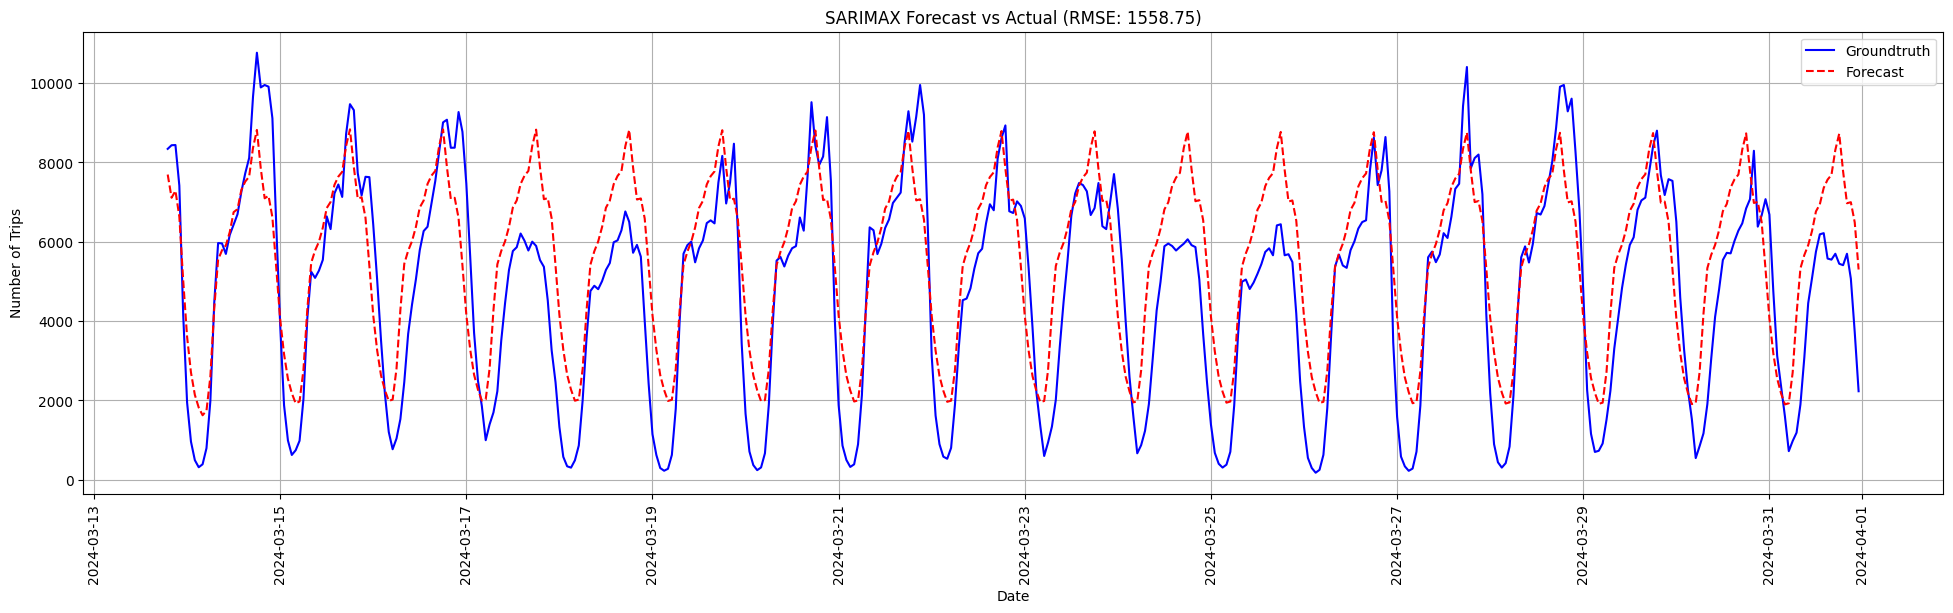

In [18]:
# Plot hourly demand
plt.figure(figsize=(24, 6))
plt.plot(test.index, test["TotalTripsfrom_thishour_till_nexthour"], label="Groundtruth", color="blue")
plt.plot(forecast.index, forecast.values, label="Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.title(f"SARIMAX Forecast vs Actual (RMSE: {rmse_SARIMAX:.2f})")
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.grid(True)
plt.show()

# Model Training - XGBOOST

In [19]:
# Delete df
del df 

# Reload df
df = dataset.copy()

# Load data
df.set_index("tpep_pickup_datetime", inplace=True)

# Feature Engineering
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month

# Define features and target variable
X = df[["hour", "day_of_week", "month"]]
y = df["TotalTripsfrom_thishour_till_nexthour"]

# Split into training and testing sets
train_size = int(len(X) * 0.8)  # 80% training, 20% testing
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print(X_train.shape, X_test.shape)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, objective="reg:squarederror")
xgb_model.fit(X_train, y_train)

# Predict on test set
xgboost_predictions = xgb_model.predict(X_test)

rmse_XGBOOST = root_mean_squared_error(y_test, xgboost_predictions)
print(f"RMSE XGBOOST: {rmse_XGBOOST}")


(1747, 3) (437, 3)
RMSE XGBOOST: 685.78857421875


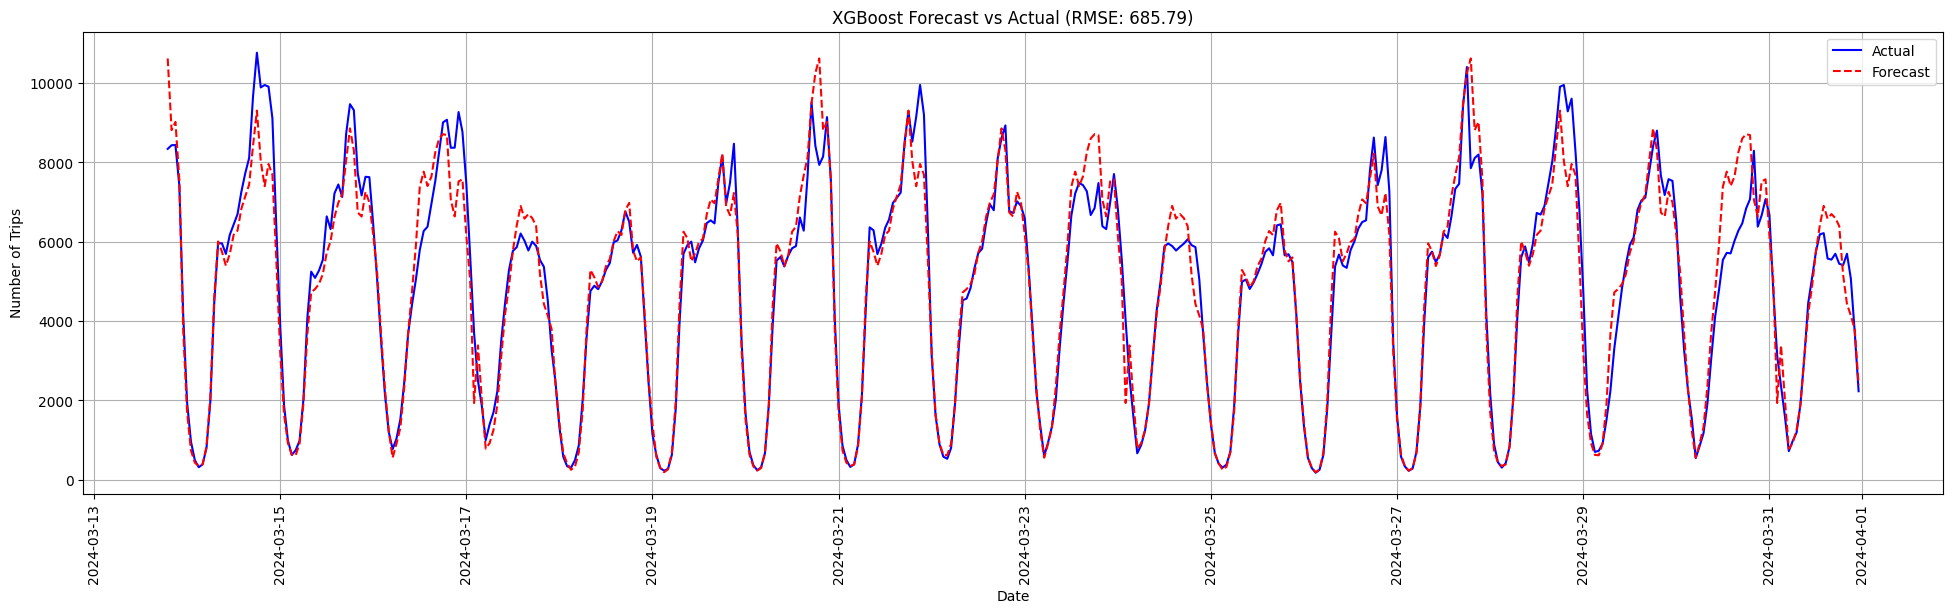

In [20]:
# Plot actual vs predicted values
plt.figure(figsize=(24, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, xgboost_predictions, label="Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.title(f"XGBoost Forecast vs Actual (RMSE: {rmse_XGBOOST:.2f})")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

# XGBOOST with Engineered Features

In [21]:
try:
    del df
except NameError:
    print("df does not exist.")

try:
    del xgb_model
except NameError:
    print("df xgb_model not exist.")

try:
    del df_xgboost
except NameError:
    print("df_xgboost xgb_model not exist.")


# Feature Engineering for XGBOOST
df_xgboost = dataset.copy()

# Set index
df_xgboost.set_index("tpep_pickup_datetime", inplace=True)

# Create time-based features
df_xgboost["hour"] = df_xgboost.index.hour.astype(int)
df_xgboost["dayofweek"] = df_xgboost.index.dayofweek.astype(int)
df_xgboost["dayofmonth"] = df_xgboost.index.day.astype(int)
df_xgboost["month"] = df_xgboost.index.month.astype(int)

# Create Lagging features
df_xgboost["hourly_pickups_lag_1"] = df_xgboost["TotalTripsfrom_thishour_till_nexthour"].shift(1)

# Drop NA
df_xgboost.dropna(inplace=True)

# Define features and target variable
X = df_xgboost[["hour", "dayofweek", "dayofmonth", "month", "hourly_pickups_lag_1"]]
y = df_xgboost["TotalTripsfrom_thishour_till_nexthour"]

# Split into training and testing sets
train_size = int(len(X) * 0.8)  # 80% training, 20% testing
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print(X_train.shape, X_test.shape)

# Initialize and train the model
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, objective="reg:squarederror")
xgb_model.fit(X_train, y_train)

# Predict on test data
xgboost_predictions = xgb_model.predict(X_test)

# RMSE
rmse_XGBOOST = root_mean_squared_error(y_test.to_numpy(), xgboost_predictions)
print(f"RMSE XGBOOST: {rmse_XGBOOST}")


df_xgboost xgb_model not exist.
(1746, 5) (437, 5)
RMSE XGBOOST: 508.591552734375


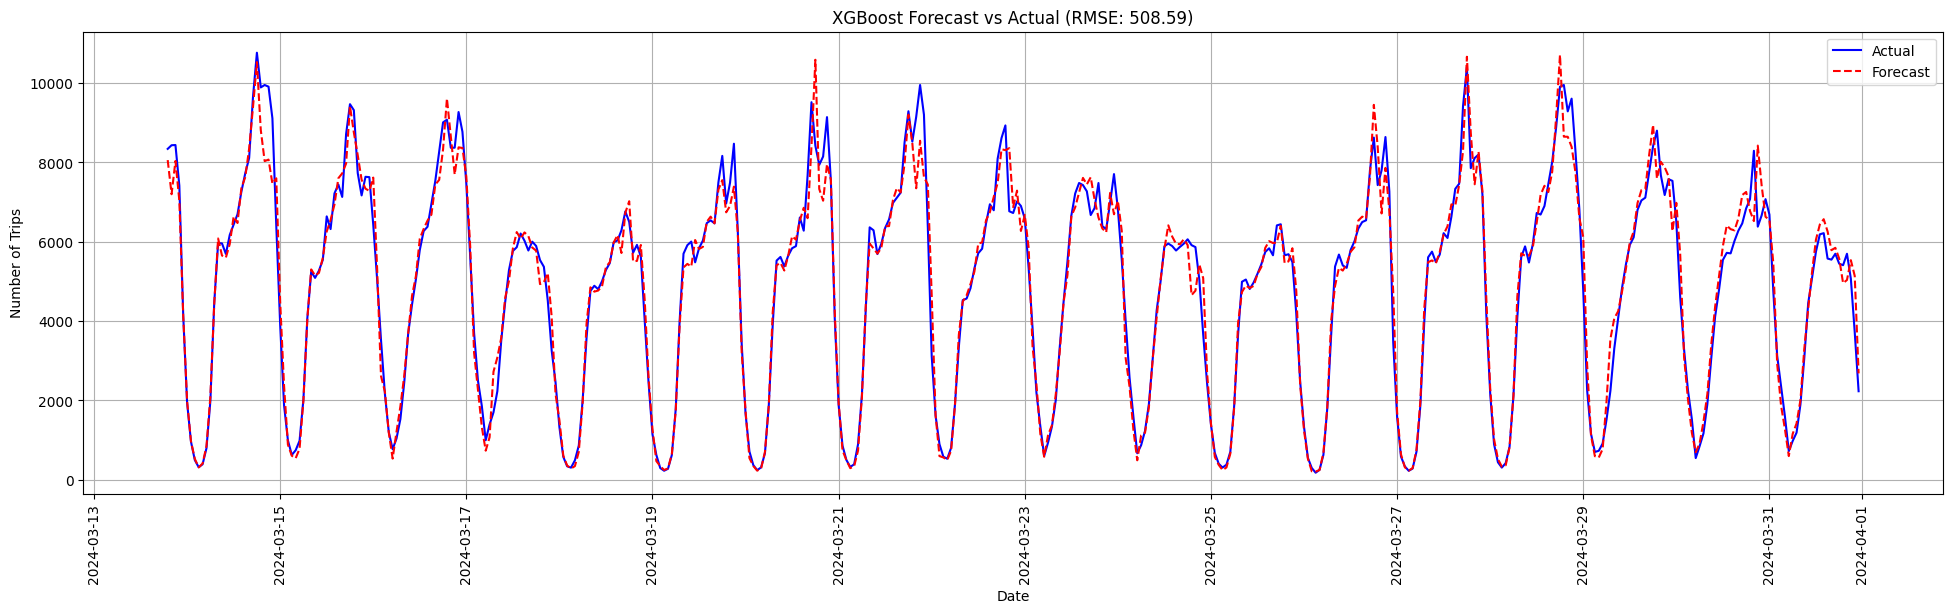

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(24, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, xgboost_predictions, label="Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.title(f"XGBoost Forecast vs Actual (RMSE: {rmse_XGBOOST:.2f})")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

# LSTM

Please refer to the PDF